In [4]:
# -*- coding: utf-8 -*-
# based on https://danijar.com/variable-sequence-lengths-in-tensorflow/

import numpy as np
import random
import functools
import tensorflow as tf
import time
import re #regexp

from tensorflow.python.ops import rnn_cell, rnn
from sklearn.metrics import confusion_matrix #compute confusion_matrix
from matplotlib import pyplot as plt #display confusion_matrix

family = 'Object' 

directory = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/'
directory_dataset = directory + 'data_nathan/'

file_training = "training.txt"
file_testing = "testing.txt" 

feat_size = 63 #21 joints * 3 dimensions (xyz)

batch_size = 20
padding_size = 300

# Parameters
learning_rate = 0.003
n_epochs = 100

# Network Parameters
seq_max_len = padding_size # Sequence max length
n_hidden = 100 # hidden layer num of features
max_seq_l = 120

p_dropout = 0.5


In [5]:
#Extract action-to-group dictionary & group labels
def action_to_group (location, family):

    with open(location, 'r') as f:
        pattern = '_(\w+)' #for Object by default
        if family == 'Motion': pattern = '(\w+)_' #add patterns like this as a list
        regexp = re.compile(pattern)
        get = re.findall( regexp, f.read() )

    atog = list() #action to group dictionary 
    g_labels = list() 
    for i in get:
        #check if group already exists
        if i not in g_labels: #extract group number as index of word in submitted & add it to action group dictionary
            g_labels.append(i)
        atog.append( g_labels.index(i) ) 

    #num_g = len(g_labels) FYI
    
    return (atog, g_labels) 

def read_data(filename):
    # Reads file containing features and returns features indexed by time
    x = []
    tmp_length = 0
    with open(filename) as f:
        for line in f:
            numbers_str = line.split()
            nums_float = [float(a) for a in numbers_str]
            x.append(nums_float)
            tmp_length =tmp_length+1
            # print(len(x))
    # x.extend([[0.0]*feat_size]*(padding_size-len(x)+1))
    f.close() #necessary ? supposed to be automatic
    tmp_val = np.min([tmp_length-1,max_seq_l])
    #print(tmp_val)
    return x[1:]  # ignore de first line (num of frames)

def read_config(filename):
    # Reads config file and returns filenames and class label
    x = []
    with open(filename) as f:
        for line in f:
            line_split = line.split()
            x.append(line_split)
    f.close()
    return x

# one hot encoding
def num_to_idx(num, num_classes):
    vec = np.zeros( shape=num_classes, dtype=np.float) #hardcode here
    vec[num] = 1
    return vec

In [6]:
#Called once to load training/testing data in MODEL
def create_dataset(filename, atog, group_number):
    # dataset is organized as NxLxD (N = num samples, L temporal length with padding, D feature dimension
    # labels is NxY where Y is one hot label vector

    dataset, labels, lengths = [], [], []
    files = read_config(filename)
    
    if group_number == -2: #groupRNN to subnets
        pass
    elif group_number == -1: #main RNN
        num_classes = max(atog) + 1 # as labelled 0 to 25 but want 26 as number of classes
    else: #subnets
        gtoa = group_to_action(atog) 
        list_actions = gtoa[group_number] #gives list of actions in current group number
        num_classes = len(list_actions)
        
    for i in files:
        
        if group_number == -2: #Feed output of groupRNN to pre-trained subnet
            
            tmp_data = read_data(directory_dataset + i[0]) #i[0] =  a01s01r01.txt (for eg)
            tmp_labels = int(i[1]) #will one hot out of here as first need to dispatch data to relevant subnet using labels
        
        elif group_number == -1: #Build group main RNN
            
            tmp_data = read_data(directory_dataset + i[0]) 
            num =  atog[ int( i[1] )] #only used for one hot encoding in the line below
            tmp_labels = np.transpose(num_to_idx(num, num_classes)) 
            #i[0] =  a01s01r01.txt (for eg)
            #i[1] = number between 0 and 44 (or as many classes there is)
            #tmp_labels = [0, 0, 1, 0, .. 0] = one-hot encoding of class value
            #tmp_data = list with variable len around 300 & each item in the list is a nested list of len 63 (=feat_size)
        
        else: #Build action subnet RNN 
            
            num = int( i[1] ) #original action number
            if num in list_actions: #select data only if belongs to group 
                tmp_data = read_data(directory_dataset + i[0]) #add to dataset if part of the group
                tmp_labels = np.transpose(num_to_idx(list_actions.index(num), num_classes)) #add labels as well     
            else: continue
            
        if len(tmp_data)<300: #why 300, is that the longest sequence ? 300 = padding_size btw...
            
            #records tmp_data initial length before padding
            #pads tmp_data with zeros until padding_size (300) so len(tmp_data) = 300 always with len 63 items
                
            lengths.append(len(tmp_data))
            tmp_data.extend([ [0.0] * feat_size ] * (padding_size - len(tmp_data)))  

            dataset.append(tmp_data)
            labels.append(tmp_labels) 
        
    # all 0..565 lists with item as nested lists of size (300, 26, 1)
    return dataset, labels, lengths

#Called once when training RNN
def batch_generation(data,labels,lengths):
    
    num_classes = np.size(labels,1) #labels is a one hot encoded numpy array. This returns number of columns (=groups).
    
    nsamples,_,_ = data.shape

    indices = np.arange(nsamples)
    np.random.shuffle(indices)
    num_batches = int(np.floor(nsamples/batch_size))
    not_exact = 0

    if nsamples%batch_size != 0:
        not_exact = 1

    batches_data = np.empty(shape=[num_batches+not_exact,batch_size,padding_size,feat_size])
    batches_labels = np.empty(shape=[num_batches+not_exact,batch_size,num_classes]) #hardcode here with num_classes
    batches_lengths = np.empty(shape=[num_batches + not_exact, batch_size],dtype=np.int32)

    for x in range(num_batches):
        batches_data[x, :, :, :] = data[indices[batch_size*x:batch_size*(x+1)], :, :]
        batches_labels[x,:,:] = labels[indices[batch_size*x:batch_size*(x+1)], :]
        batches_lengths[x,:] = lengths[indices[batch_size*x:batch_size*(x+1)]]

    if not_exact > 0:
        to_complete = nsamples%batch_size
        tmp_data = data[indices[batch_size*num_batches:batch_size*num_batches+to_complete],:,:]
        tmp_random = np.random.randint(0,nsamples-to_complete,batch_size-to_complete) # we complete last batch with random samples

        batches_data[num_batches]=np.concatenate((tmp_data,data[tmp_random,:,:]),axis=0)

        tmp_labels = labels[indices[batch_size*num_batches:batch_size*num_batches+to_complete],:]
        batches_labels[num_batches] = np.concatenate((tmp_labels,labels[indices[tmp_random],:]))
        tmp_lengths = lengths[indices[batch_size*num_batches:batch_size*num_batches+to_complete]]
        batches_lengths[num_batches] = np.concatenate((tmp_lengths,lengths[indices[tmp_random]]))

    return batches_data, batches_labels, batches_lengths, num_batches+not_exact

In [7]:
def dynamicRNN(x, seqlen, weights, biases, keep_prob):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, feat_size])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(x, seq_max_len, 0) # tf.split(value, num_or_size_splits, axis)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
    
    #Operator adding dropout to inputs and outputs of the given cell.
    lstm_cell_dropout = rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob = keep_prob) 
    
    #Added to have 2 layers LSTM, not used here.
    layers = 1
    final_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell_dropout] * layers)

    # Get lstm cell output, providing 'sequence_length' will perform dynamic calculation.
    outputs, states = tf.contrib.rnn.static_rnn(final_cell, x, dtype=tf.float32, sequence_length=seqlen)
    
    # When performing dynamic calculation, we must retrieve the last
    # dynamically computed output, i.e, if a sequence length is 10, we need
    # to retrieve the 10th output.
    # However TensorFlow doesn't support advanced indexing yet, so we build
    # a custom op that for each sample in batch size, get its length and
    # get the corresponding relevant output.

    # 'outputs' is a list of output at every timestep, we pack them in a Tensor
    # and change back dimension to [batch_size, n_step, n_input]
    outputs = tf.stack(outputs)
    outputs = tf.transpose(outputs, [1, 0, 2])

    # Hack to build the indexing and retrieve the right output.
    batch_size = tf.shape(outputs)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size) * seq_max_len + (seqlen - 1)
    # Indexing
    outputs = tf.gather(tf.reshape(outputs, [-1, n_hidden]), index)

    # Linear activation, using outputs computed above
    return tf.matmul(outputs, weights['out']) + biases['out']

In [8]:
def doMyRNN(location, family, group_number):

    # ==========
    #   MODEL
    # ==========
    print('in MODEL')

    tf.reset_default_graph() #Clear computational graph to prevent error
    
    # Load training and testing data
    (atog, _) = action_to_group(location, family)
    train_data, train_labels, train_lengths = create_dataset(file_training, atog, group_number)
    test_data, test_labels, test_lengths = create_dataset(file_testing, atog, group_number)

    #cast to numpy array
    train_data = np.asarray(train_data)
    train_labels = np.asarray(train_labels)
    train_lengths = np.asarray(train_lengths,dtype=np.int32)
    test_data = np.asarray(test_data)
    test_labels = np.asarray(test_labels)
    test_lengths = np.asarray(test_lengths)

    (samples, rows, row_size) = train_data.shape

    n_classes = np.size(train_labels,1)

    # tf Graph input
    x = tf.placeholder("float", [None, seq_max_len, feat_size], name="x")
    y = tf.placeholder("float", [None, n_classes], name="y")

    # A placeholder for indicating each sequence length
    seqlen = tf.placeholder(tf.int32, [None], name="seqlen")

    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")

    # ==========
    #   LAUNCH
    # ==========
    print('in LAUNCH')

    pred = dynamicRNN(x, seqlen, weights, biases, keep_prob)

    # Evaluate model 
    prediction = tf.argmax(pred,axis=1, name="prediction") # for each prediction, keep class with highest level of confidence (tests X classes)
    correct_pred = tf.equal(prediction, tf.argmax(y,1)) #output 0 & 1 vector, y is supposed to have true labels
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32)) #mean of above

    #Create a saver object which will save all the variables
    #saver = tf.train.Saver()

    # ============
    #   OPTIMIZE
    # ============
    print('in OPTIMIZE')

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y))
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    # optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()
    
    #Create a saver object which will save all the variables
    saver = tf.train.Saver() 
    if group_number == -1 :
        saved_path = directory + 'saved_sessions/group_RNN/' + family 
    else:
        saved_path = directory + 'saved_sessions/subnets/' + family + '/subnet_' + str(group_number)

    # Launch the graph
    with tf.Session() as sess:

        sess.run(init)

        max_acc = 0.0;
        max_epoch = 0;
        best_labels = []

        # Keep training until reach max iterations
        for epoch in range(n_epochs):
            
            (batch_x, batch_y, batch_seqlen, n_batches) = batch_generation(train_data, train_labels, train_lengths)

            start = time.time()

            for i in range(n_batches):

                # Run optimization op (backprop)
                sess.run(optimizer, feed_dict={x: batch_x[i,:,:,:], y: batch_y[i,:,:],
                                               seqlen: batch_seqlen[i,:], keep_prob: p_dropout})

            # Test accuracy on this epoch    
            test_acc = sess.run(accuracy, feed_dict={x: test_data, y: test_labels, seqlen: test_lengths, keep_prob: 1.0})

            #Save best testing results
            if test_acc > max_acc: 
                
                #Save the best accuracy and predictions
                max_acc = test_acc; max_epoch = epoch
                #gives the confidence score of every class at output along columns (dim 1)
                labels = pred.eval(feed_dict={x: test_data, y: test_labels, seqlen: test_lengths, keep_prob: 1.0})
                # pred_labels = tf.argmax(labels, 1) OR
                pred_labels = prediction.eval(feed_dict={x: test_data, y: test_labels, seqlen: test_lengths, keep_prob: 1.0})
                #test_labels is one_hot. Want 1-D like best_labels
                true_labels = np.asarray( [ np.where(r==1)[0][0] for r in test_labels ], dtype=np.int64)

                #Save best
                saver.save(sess, saved_path)
                print('Saved subnet at epoch ' + str(epoch) + ' at ' + saved_path)

            print('Epoch {:2d} accuracy {:3.1f}% in {:3.1f} seconds'.format(epoch, 100 * test_acc, time.time() - start))
            print('max_acc {:3.1f}% at epoch {:2d} \n'.format(max_acc*100, max_epoch))
            
            #Stop training when accuracy is maximum
            if max_acc == 1: 
                print('Reached 100% accuracy -> exit training \n')
                break
             
        print ("Optimization Finished!")

        return (labels, pred_labels, true_labels)

        # ToDo
        # Get training accuracy and plot it along test accuracy 
        # Add a validation set accuracy to train without overfitting


In [9]:
#Display confusion matrix
def confusion_mtx(true, pred, name_labels):
    
    num_classes = len(name_labels)
    cm = confusion_matrix(true, pred)

    fig = plt.figure(figsize=(10,10), dpi=100)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    plt.xticks(range(num_classes), name_labels, rotation=90)
    plt.yticks(range(num_classes), name_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    #TODO
    #Adjust the matrix scale (0 to 45 to the relevant scaling 0 to 100%)
    #Have a checkerboard figure to track classes easily
    #Have white background for better error reading for colorbar
    #Rotate 45 the vertical axis
    #Write number of successful matches inside the box (especially good for subnets)

#Display confidence level bar histogram 
def confidence_probability_g (scores, pred_class, true_class, g_labels):
    
    format_scores = scores - np.amin(scores)
    format_scores = format_scores / np.amax(format_scores)
    
    #y = scores
    y = format_scores #probabilities made from normalising on this 1 score (not on the 569 scores)
    x = range(len(scores)) #as much scores as there is in y (45)
    
    plt.figure(figsize=(20,4))
    
    barlist = plt.bar(x,y, width=0.7)

    import randomcolor
    colors = randomcolor.RandomColor().generate(count=len(g_labels)) #as many group or actions    
    for i in range(len(barlist)): barlist[i].set_color(colors[i])
    
    plt.title('Predicted class ' + str(pred_class) + ' ' + g_labels[pred_class] 
                 + ' for class ' + str(true_class) + ' ' + g_labels[true_class],
                 fontsize=18)
    
    plt.xticks(x, g_labels, rotation=90, fontsize=18)
    
    plt.show()
    
    #ToDo
    # Be able to know the name of sample seq that fails 

In [10]:
def get_group_labels(group_number):
    with open(directory + 'labels/name_of_labels_original.txt') as f:
        all_45_action_labels = [word for line in f for word in line.split()]
    action_labels_inside_this_group = [all_45_action_labels[i] for i in range(len(atog)) if atog[i] == group_number]
    return action_labels_inside_this_group

def group_to_action(atog):
    gtoa = []
    for group_number in range(max(atog)+1):
        gtoa.append( [index for index, value in enumerate(atog) if value == group_number] )
    return gtoa

**Execution - Group RNN **

In [8]:
#Train group RNN on classifying the object group

#Load group dico and labels
location = directory + 'labels/grouping_1/object_group_labels.txt'

(labels, pred_labels, true_labels) = doMyRNN(location, family, -1) #-1 as this is a main group net (not subnet)

#Save on disk to not have to retrain to get results
location = directory + 'results/group_RNN/' + family + '/'
np.save(location + 'labels.npy', labels)    # .npy extension is added if not given
np.save(location + 'pred_labels.npy', pred_labels) 
np.save(location + 'true_labels.npy', true_labels) 

in MODEL
in LAUNCH
in OPTIMIZE


/home/nathan/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/group_RNN/Object
Epoch  0 accuracy 23.0% in 104.2 seconds
max_acc 23.0% at epoch  0 

Saved subnet at epoch 1 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/group_RNN/Object
Epoch  1 accuracy 31.3% in 16.7 seconds
max_acc 31.3% at epoch  1 

Epoch  2 accuracy 28.5% in 8.7 seconds
max_acc 31.3% at epoch  1 

Saved subnet at epoch 3 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/group_RNN/Object
Epoch  3 accuracy 37.8% in 17.0 seconds
max_acc 37.8% at epoch  3 

Epoch  4 accuracy 34.8% in 8.3 seconds
max_acc 37.8% at epoch  3 

Epoch  5 accuracy 36.9% in 8.5 seconds
max_acc 37.8% at epoch  3 

Saved subnet at epoch 6 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/group_RNN/Object
Epoch  6 accuracy 46.0% in 16.5 seconds
max_acc 46.0% at epoch  6 

Epoch  7 accuracy 40.8% in 9.2 seconds
max_acc 46.0% at epoch  6 

Saved subnet at epoch 8 at /hom

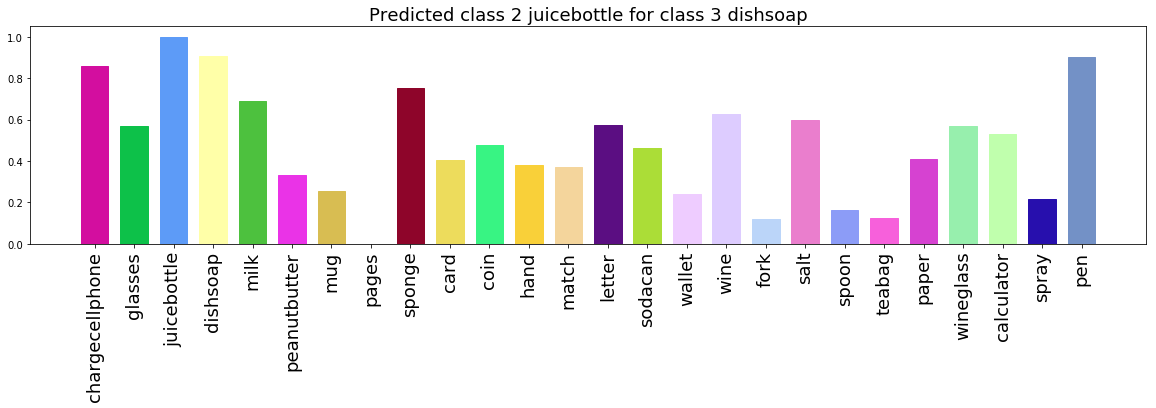

Group Object Accuracy 73.99 % with 26 groups


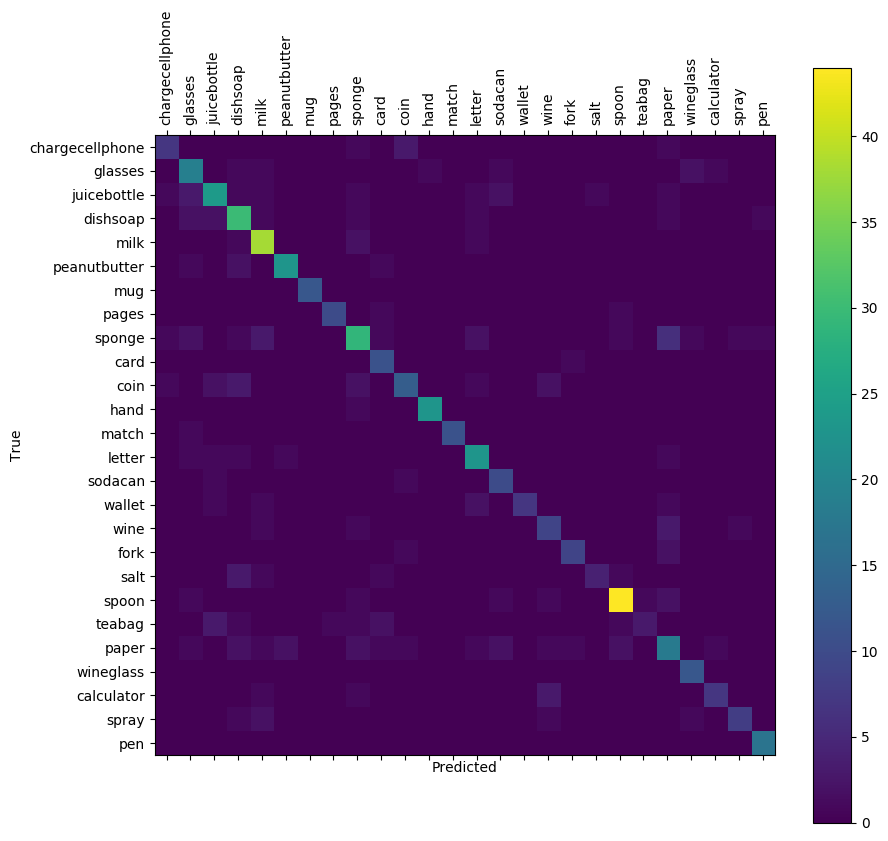

In [9]:
#Analyze Object group RNN results

#Load variables to analyze
location = directory + 'results/group_RNN/' + family + '/'
(labels, pred_labels, true_labels) = ( np.load(location + 'labels.npy'), 
                                       np.load(location + 'pred_labels.npy'),
                                       np.load(location + 'true_labels.npy') )
location = directory + 'labels/grouping_1/object_group_labels.txt'
(_, g_labels) = action_to_group(location, family)

# Run analysis: score, accuracy, conf_mat
ite = 7
confidence_probability_g (labels[ite,:], pred_labels[ite], true_labels[ite], g_labels)
correct_pred = np.equal(true_labels, pred_labels) #output 0 & 1 vector
acc = np.mean(correct_pred) #mean of above
print('Group %s Accuracy %.2f %% with %i groups' % (family, float(100*acc), len(g_labels)))
confusion_mtx(true_labels, pred_labels, g_labels)

**Execution - Subnets RNN **

in MODEL
in LAUNCH
in OPTIMIZE


/home/nathan/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_1
Epoch  0 accuracy 46.2% in 90.8 seconds
max_acc 46.2% at epoch  0 

Saved subnet at epoch 1 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_1
Epoch  1 accuracy 53.8% in 5.7 seconds
max_acc 53.8% at epoch  1 

Saved subnet at epoch 2 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_1
Epoch  2 accuracy 61.5% in 5.8 seconds
max_acc 61.5% at epoch  2 

Saved subnet at epoch 3 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_1
Epoch  3 accuracy 84.6% in 5.7 seconds
max_acc 84.6% at epoch  3 

Saved subnet at epoch 4 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_1
Epoch  4 accuracy 88.5% in 5.7 seconds
max_acc 88.5% at epoch  4 

Epoch  5 accuracy 88.5% in 0.4 seconds
max_acc 88.5% at epoch  4 

Saved subnet at epoch 6 at 

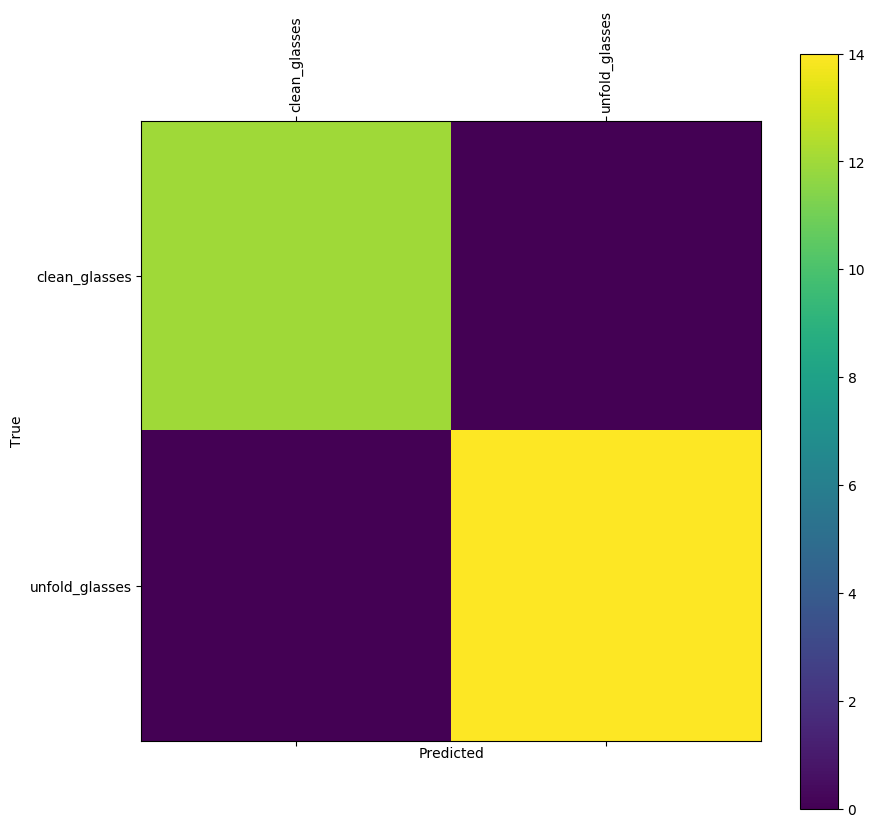

in MODEL
in LAUNCH
in OPTIMIZE
Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_2
Epoch  0 accuracy 61.1% in 91.5 seconds
max_acc 61.1% at epoch  0 

Epoch  1 accuracy 58.3% in 0.6 seconds
max_acc 61.1% at epoch  0 

Saved subnet at epoch 2 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_2
Epoch  2 accuracy 83.3% in 6.7 seconds
max_acc 83.3% at epoch  2 

Epoch  3 accuracy 75.0% in 0.5 seconds
max_acc 83.3% at epoch  2 

Epoch  4 accuracy 72.2% in 0.5 seconds
max_acc 83.3% at epoch  2 

Epoch  5 accuracy 83.3% in 0.5 seconds
max_acc 83.3% at epoch  2 

Epoch  6 accuracy 72.2% in 0.6 seconds
max_acc 83.3% at epoch  2 

Epoch  7 accuracy 77.8% in 0.6 seconds
max_acc 83.3% at epoch  2 

Epoch  8 accuracy 83.3% in 0.6 seconds
max_acc 83.3% at epoch  2 

Saved subnet at epoch 9 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_2
Epoch  9 accuracy 86.1%

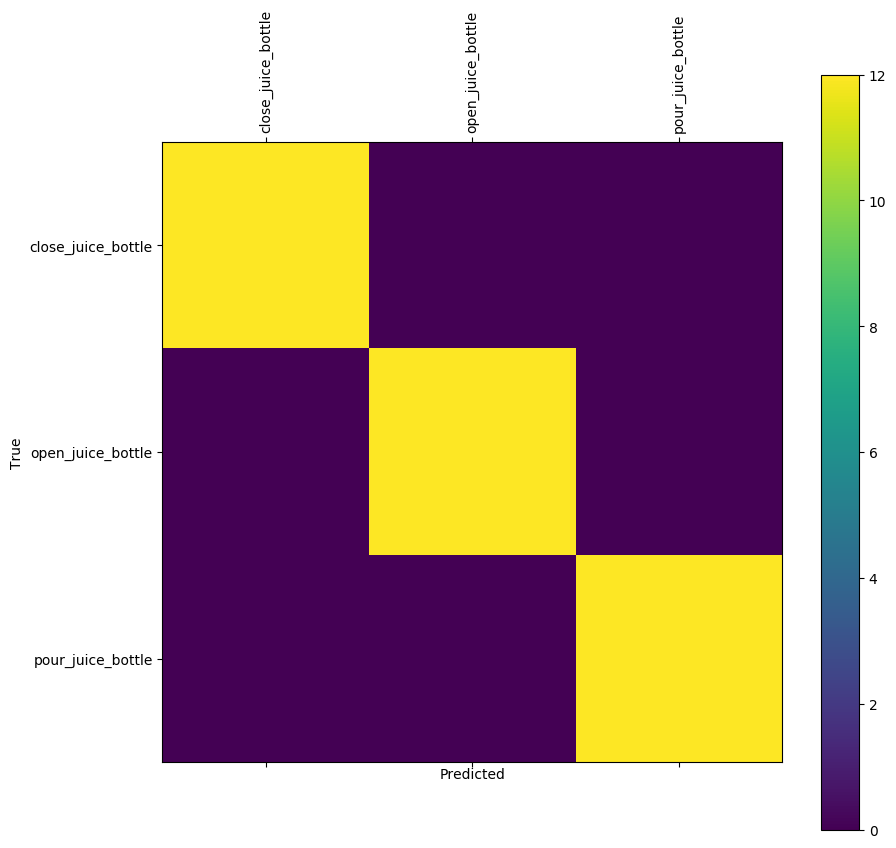

in MODEL
in LAUNCH
in OPTIMIZE
Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_3
Epoch  0 accuracy 38.5% in 767.7 seconds
max_acc 38.5% at epoch  0 

Saved subnet at epoch 1 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_3
Epoch  1 accuracy 48.7% in 6.3 seconds
max_acc 48.7% at epoch  1 

Saved subnet at epoch 2 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_3
Epoch  2 accuracy 51.3% in 6.1 seconds
max_acc 51.3% at epoch  2 

Saved subnet at epoch 3 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_3
Epoch  3 accuracy 69.2% in 6.0 seconds
max_acc 69.2% at epoch  3 

Epoch  4 accuracy 53.8% in 0.6 seconds
max_acc 69.2% at epoch  3 

Saved subnet at epoch 5 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_3
Epoch  5 accuracy 71.8% in 5.9 seconds
max_acc 71.8% at epoch 

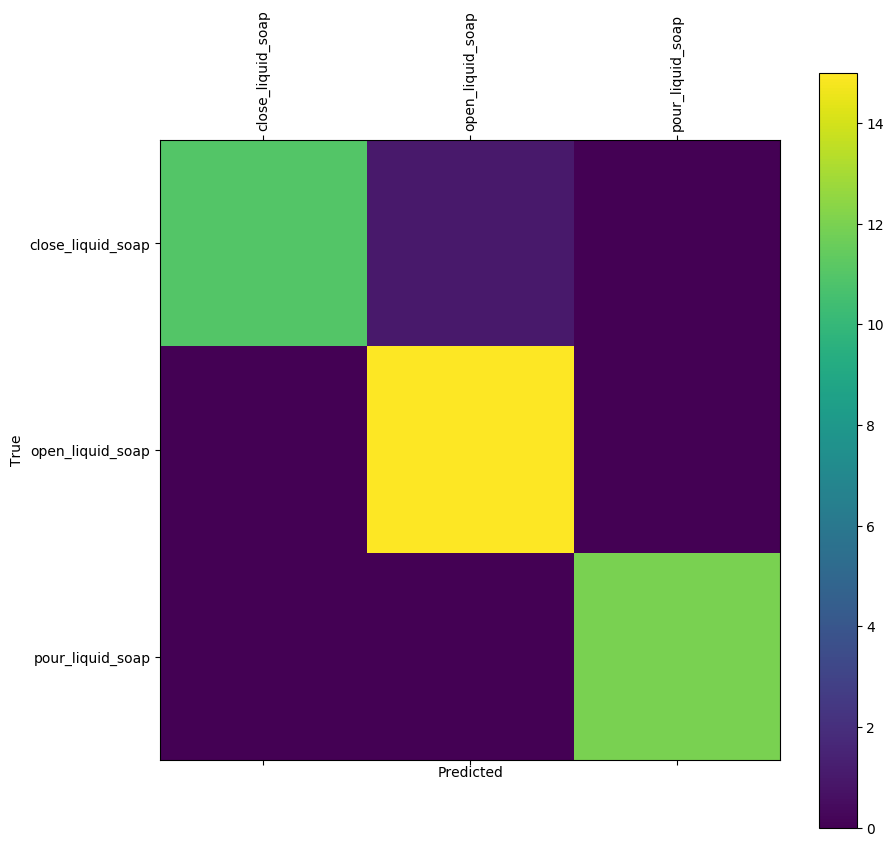

in MODEL
in LAUNCH
in OPTIMIZE
Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_4
Epoch  0 accuracy 40.5% in 100.7 seconds
max_acc 40.5% at epoch  0 

Saved subnet at epoch 1 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_4
Epoch  1 accuracy 61.9% in 7.0 seconds
max_acc 61.9% at epoch  1 

Epoch  2 accuracy 47.6% in 0.8 seconds
max_acc 61.9% at epoch  1 

Saved subnet at epoch 3 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_4
Epoch  3 accuracy 64.3% in 6.3 seconds
max_acc 64.3% at epoch  3 

Epoch  4 accuracy 61.9% in 1.0 seconds
max_acc 64.3% at epoch  3 

Saved subnet at epoch 5 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_4
Epoch  5 accuracy 69.0% in 7.5 seconds
max_acc 69.0% at epoch  5 

Saved subnet at epoch 6 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subn

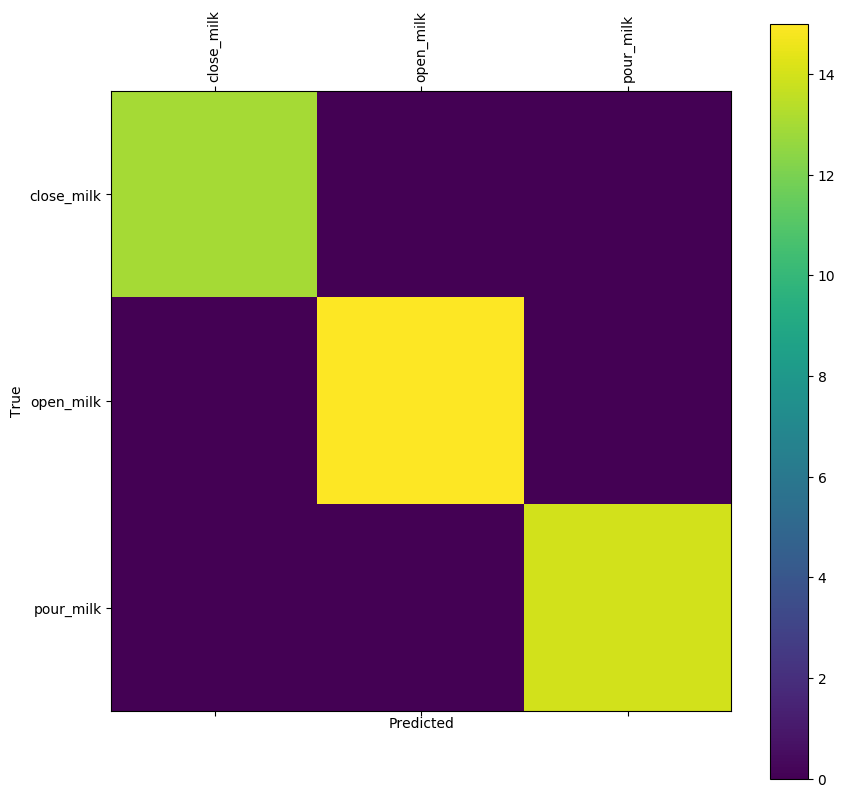

in MODEL
in LAUNCH
in OPTIMIZE
Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_5
Epoch  0 accuracy 48.1% in 112.1 seconds
max_acc 48.1% at epoch  0 

Saved subnet at epoch 1 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_5
Epoch  1 accuracy 85.2% in 7.0 seconds
max_acc 85.2% at epoch  1 

Epoch  2 accuracy 85.2% in 0.5 seconds
max_acc 85.2% at epoch  1 

Saved subnet at epoch 3 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_5
Epoch  3 accuracy 92.6% in 6.3 seconds
max_acc 92.6% at epoch  3 

Epoch  4 accuracy 88.9% in 0.6 seconds
max_acc 92.6% at epoch  3 

Epoch  5 accuracy 88.9% in 0.5 seconds
max_acc 92.6% at epoch  3 

Epoch  6 accuracy 88.9% in 0.5 seconds
max_acc 92.6% at epoch  3 

Epoch  7 accuracy 92.6% in 0.6 seconds
max_acc 92.6% at epoch  3 

Saved subnet at epoch 8 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions

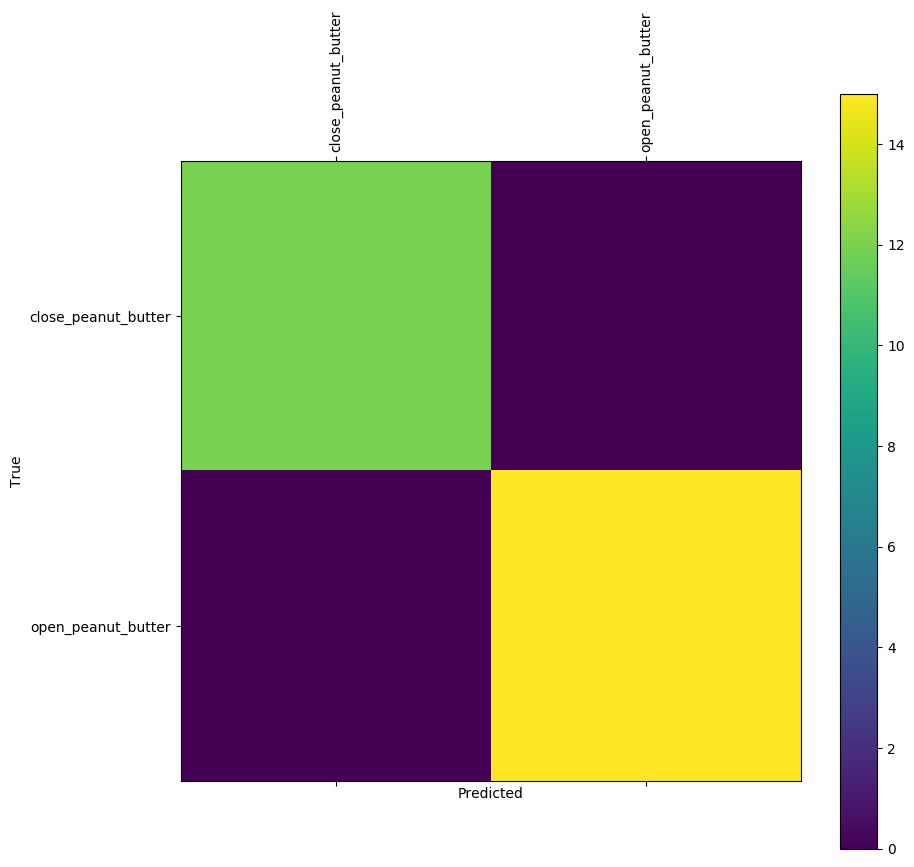

in MODEL
in LAUNCH
in OPTIMIZE
Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_8
Epoch  0 accuracy 46.9% in 97.2 seconds
max_acc 46.9% at epoch  0 

Epoch  1 accuracy 40.8% in 0.8 seconds
max_acc 46.9% at epoch  0 

Saved subnet at epoch 2 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_8
Epoch  2 accuracy 59.2% in 6.4 seconds
max_acc 59.2% at epoch  2 

Saved subnet at epoch 3 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_8
Epoch  3 accuracy 73.5% in 6.4 seconds
max_acc 73.5% at epoch  3 

Saved subnet at epoch 4 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_8
Epoch  4 accuracy 77.6% in 6.6 seconds
max_acc 77.6% at epoch  4 

Epoch  5 accuracy 77.6% in 0.9 seconds
max_acc 77.6% at epoch  4 

Epoch  6 accuracy 75.5% in 0.9 seconds
max_acc 77.6% at epoch  4 

Saved subnet at epoch 7 at /home/nathan/Doc

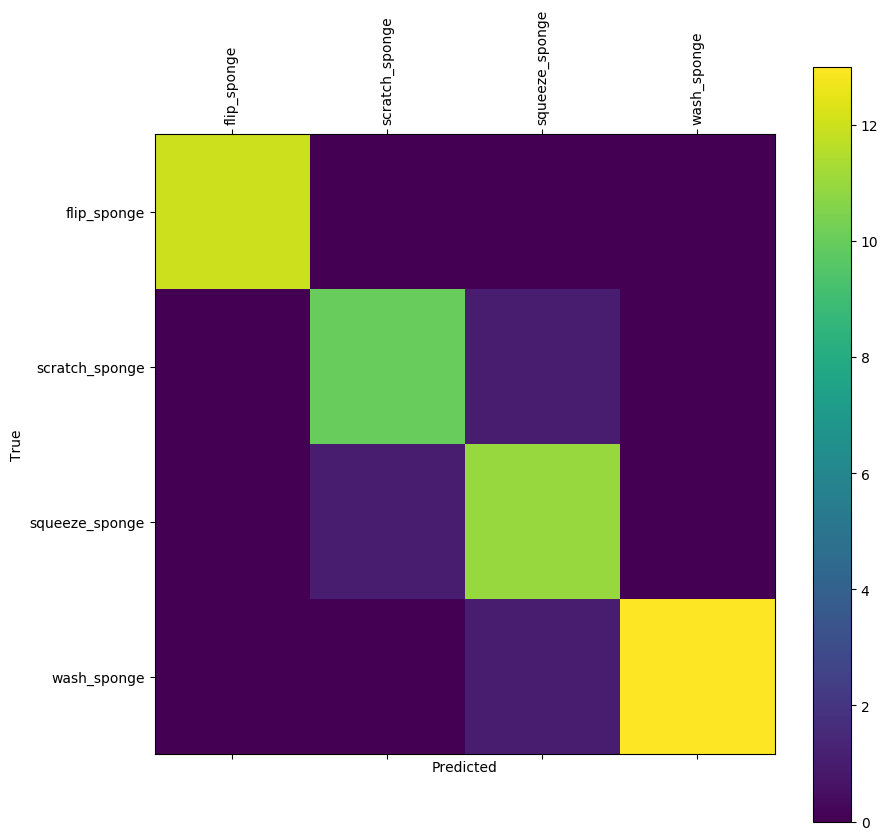

in MODEL
in LAUNCH
in OPTIMIZE
Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_10
Epoch  0 accuracy 54.2% in 96.6 seconds
max_acc 54.2% at epoch  0 

Saved subnet at epoch 1 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_10
Epoch  1 accuracy 91.7% in 6.6 seconds
max_acc 91.7% at epoch  1 

Epoch  2 accuracy 91.7% in 0.6 seconds
max_acc 91.7% at epoch  1 

Epoch  3 accuracy 91.7% in 0.6 seconds
max_acc 91.7% at epoch  1 

Epoch  4 accuracy 87.5% in 0.6 seconds
max_acc 91.7% at epoch  1 

Epoch  5 accuracy 87.5% in 0.6 seconds
max_acc 91.7% at epoch  1 

Epoch  6 accuracy 83.3% in 0.6 seconds
max_acc 91.7% at epoch  1 

Epoch  7 accuracy 87.5% in 0.6 seconds
max_acc 91.7% at epoch  1 

Epoch  8 accuracy 91.7% in 0.6 seconds
max_acc 91.7% at epoch  1 

Epoch  9 accuracy 91.7% in 0.6 seconds
max_acc 91.7% at epoch  1 

Epoch 10 accuracy 87.5% in 0.6 seconds
max_acc 91.7% at epoch  1 

E

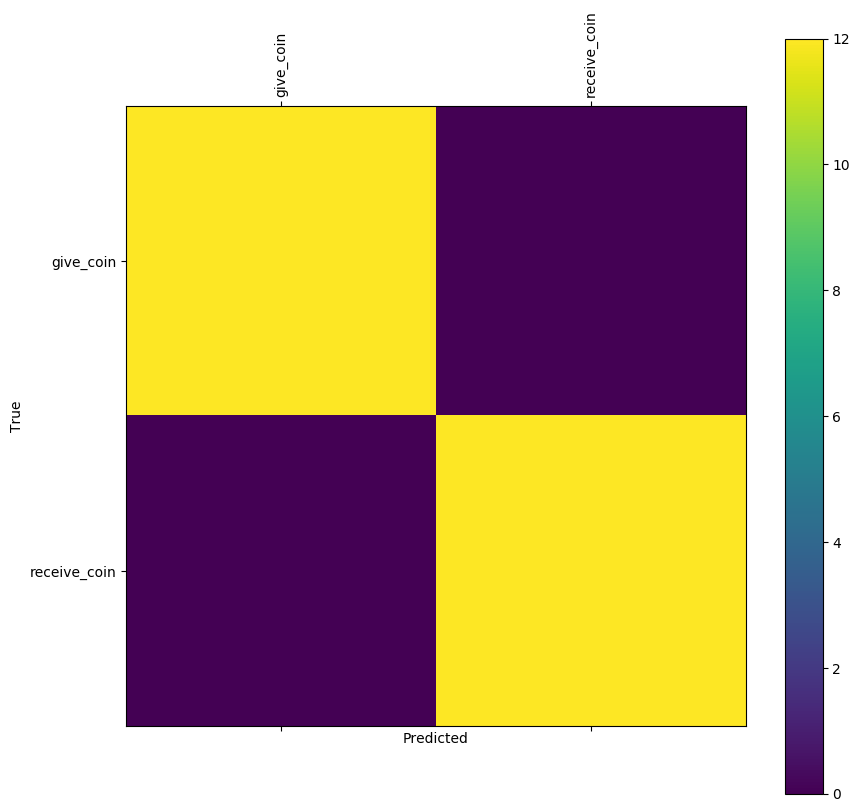

in MODEL
in LAUNCH
in OPTIMIZE
Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_11
Epoch  0 accuracy 50.0% in 92.1 seconds
max_acc 50.0% at epoch  0 

Saved subnet at epoch 1 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_11
Epoch  1 accuracy 75.0% in 6.0 seconds
max_acc 75.0% at epoch  1 

Epoch  2 accuracy 62.5% in 0.5 seconds
max_acc 75.0% at epoch  1 

Saved subnet at epoch 3 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_11
Epoch  3 accuracy 83.3% in 5.8 seconds
max_acc 83.3% at epoch  3 

Epoch  4 accuracy 79.2% in 0.5 seconds
max_acc 83.3% at epoch  3 

Epoch  5 accuracy 75.0% in 0.5 seconds
max_acc 83.3% at epoch  3 

Epoch  6 accuracy 79.2% in 0.5 seconds
max_acc 83.3% at epoch  3 

Saved subnet at epoch 7 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_11
Epoch  7 accuracy 91.7% in 5.9 seconds


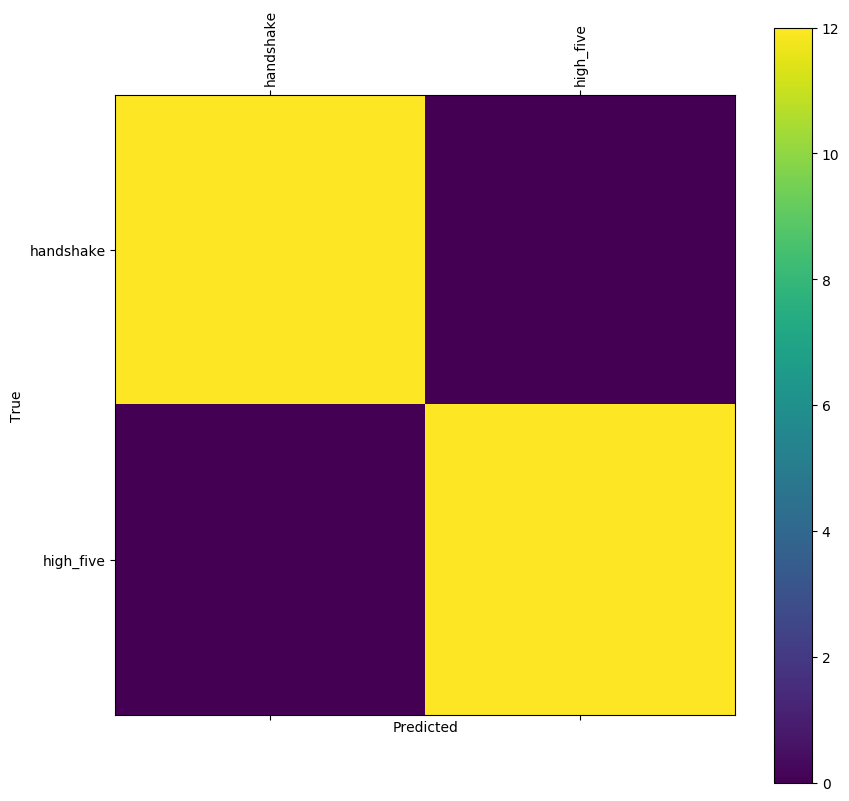

in MODEL
in LAUNCH
in OPTIMIZE
Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_13
Epoch  0 accuracy 57.1% in 92.1 seconds
max_acc 57.1% at epoch  0 

Saved subnet at epoch 1 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_13
Epoch  1 accuracy 67.9% in 6.1 seconds
max_acc 67.9% at epoch  1 

Epoch  2 accuracy 46.4% in 0.4 seconds
max_acc 67.9% at epoch  1 

Saved subnet at epoch 3 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_13
Epoch  3 accuracy 75.0% in 6.6 seconds
max_acc 75.0% at epoch  3 

Epoch  4 accuracy 64.3% in 0.3 seconds
max_acc 75.0% at epoch  3 

Epoch  5 accuracy 60.7% in 0.3 seconds
max_acc 75.0% at epoch  3 

Epoch  6 accuracy 75.0% in 0.3 seconds
max_acc 75.0% at epoch  3 

Saved subnet at epoch 7 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_13
Epoch  7 accuracy 85.7% in 6.0 seconds


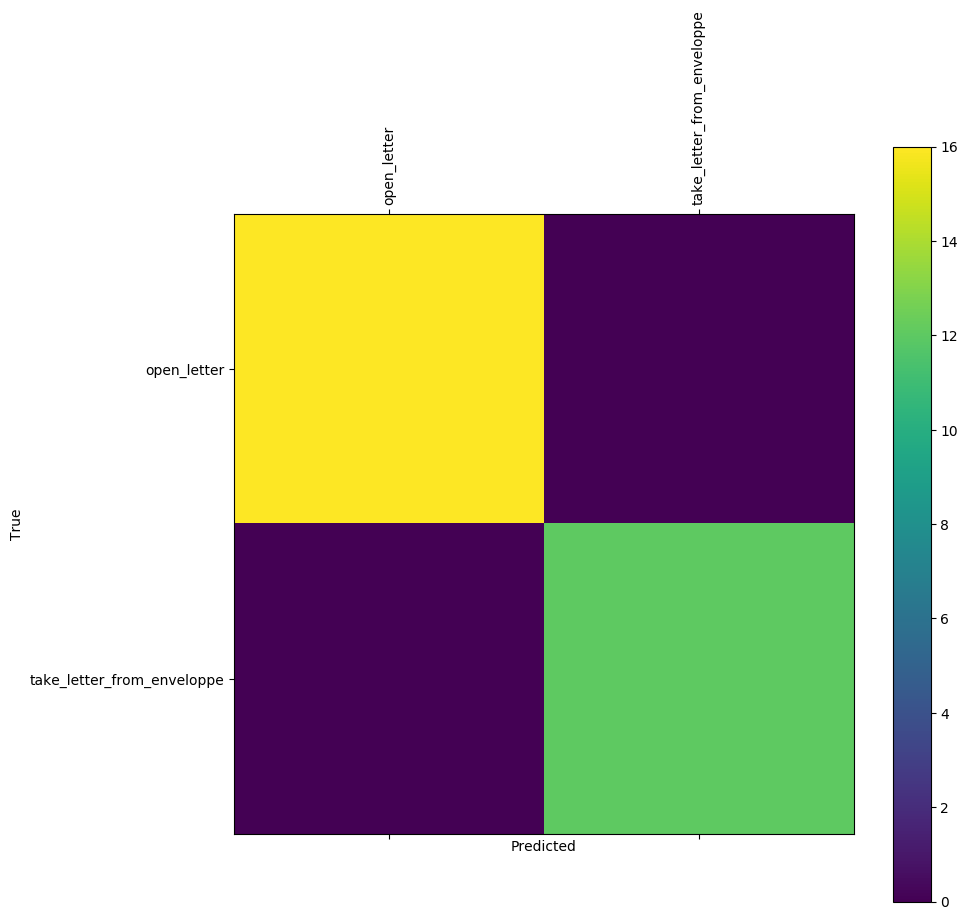

in MODEL
in LAUNCH
in OPTIMIZE
Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_19
Epoch  0 accuracy 41.2% in 92.3 seconds
max_acc 41.2% at epoch  0 

Saved subnet at epoch 1 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_19
Epoch  1 accuracy 51.0% in 6.6 seconds
max_acc 51.0% at epoch  1 

Saved subnet at epoch 2 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_19
Epoch  2 accuracy 62.7% in 6.5 seconds
max_acc 62.7% at epoch  2 

Saved subnet at epoch 3 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_19
Epoch  3 accuracy 64.7% in 6.4 seconds
max_acc 64.7% at epoch  3 

Epoch  4 accuracy 60.8% in 0.9 seconds
max_acc 64.7% at epoch  3 

Epoch  5 accuracy 52.9% in 0.9 seconds
max_acc 64.7% at epoch  3 

Saved subnet at epoch 6 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/s

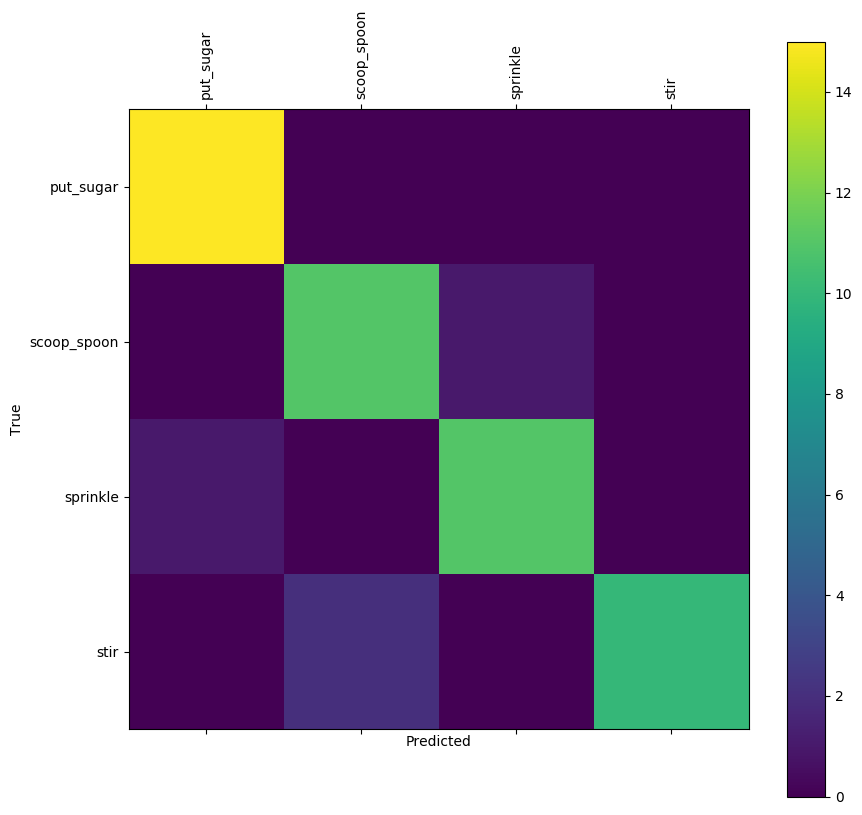

in MODEL
in LAUNCH
in OPTIMIZE
Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_21
Epoch  0 accuracy 52.8% in 96.1 seconds
max_acc 52.8% at epoch  0 

Epoch  1 accuracy 36.1% in 0.6 seconds
max_acc 52.8% at epoch  0 

Epoch  2 accuracy 50.0% in 0.5 seconds
max_acc 52.8% at epoch  0 

Saved subnet at epoch 3 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_21
Epoch  3 accuracy 61.1% in 6.4 seconds
max_acc 61.1% at epoch  3 

Saved subnet at epoch 4 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_21
Epoch  4 accuracy 63.9% in 6.1 seconds
max_acc 63.9% at epoch  4 

Saved subnet at epoch 5 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_21
Epoch  5 accuracy 66.7% in 6.0 seconds
max_acc 66.7% at epoch  5 

Saved subnet at epoch 6 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/s

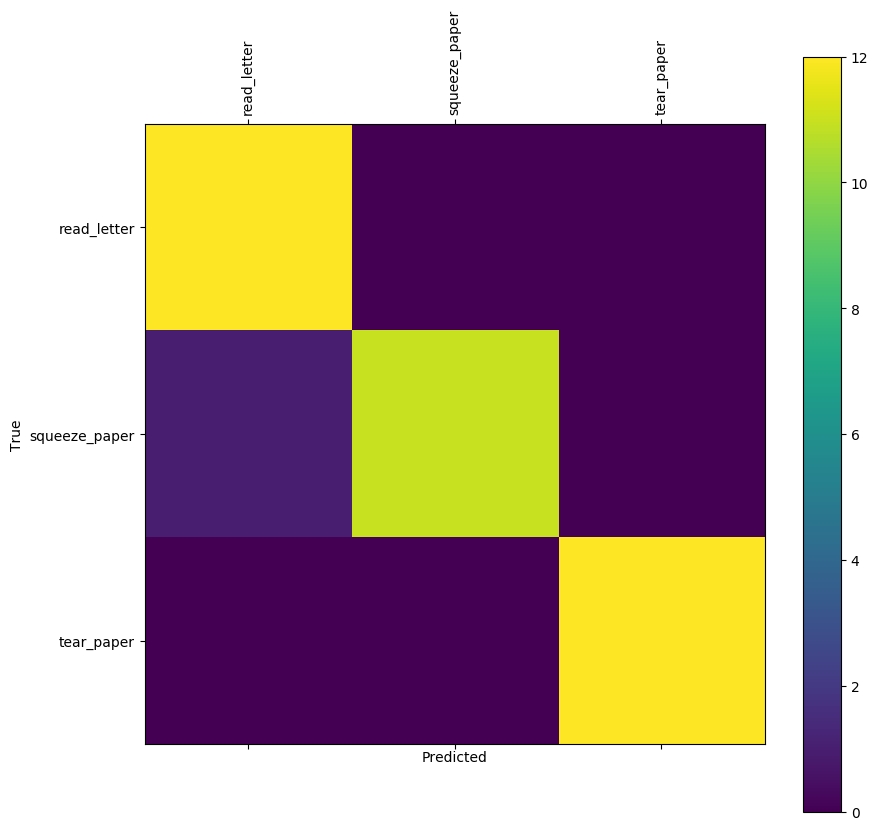

In [10]:
#Train subnets independently of group RNN 

#To visualise the whole grouping of 45 actions at once as a nested list
"""
for i in range(26):
    group_sub_labels = get_group_labels(i)
    print(group_sub_labels)
"""

#Subnets are just like the orginal RNN but with a selected number of training samples from training.txt and testing.txt

location = directory + 'labels/grouping_1/object_group_labels.txt'
(atog, g_labels) = action_to_group(location, family)

#Only build subnet for groups with more than 1 element
gtoa = group_to_action(atog); 
groups_with_subnet =  [i for i, value in enumerate(gtoa) if len(value)>1]

for group_number in groups_with_subnet:

    num_classes = gtoa[group_number] #number of classes
    group_sub_labels = get_group_labels(group_number) #labels of classes (inside this group)
    
    #trained subnet saved in doMyRNN
    (labels, pred_labels, true_labels) = doMyRNN(location, family, group_number)

    #Evaluating subnet
    acc = np.mean(np.equal(true_labels, pred_labels))
    print('Group %i "%s" - %s - accuracy: %.2f %%' % (group_number, g_labels[group_number], group_sub_labels, float(100*acc)))
    print(pred_labels)
    print(true_labels)
    print(np.equal(true_labels, pred_labels))
    confusion_mtx(true_labels, pred_labels, group_sub_labels)
    

** Gather results **

In [ ]:
#Obtain all original data
(test_data, test_labels, test_lengths) = create_dataset(file_testing, [], -2)
test_data, test_labels, test_lengths = np.asarray(test_data), np.asarray(test_labels), np.asarray(test_lengths) 

#Link groupRNN output to subnets input using pred_labels
location = directory + 'results/group_RNN/' + family + '/'
pred_labels = np.load(location + 'pred_labels.npy') 

#Only import existing subnets (groups with more than 1 action)
location = directory + 'labels/grouping_1/object_group_labels.txt'
(atog, g_labels) = action_to_group(location, family)
gtoa = group_to_action(atog); 
groups_with_subnet =  [i for i, value in enumerate(gtoa) if len(value)>1]

#Want indices out of 569 of all group_numbers with 1 action 
groups_without_subnet =  [i for i, value in enumerate(gtoa) if len(value)==1]
indices = [index for index, value in enumerate(pred_labels) if value in groups_without_subnet]
pred_labels_without, test_labels_without = pred_labels[indices], test_labels[indices]
group_test_labels_without = [atog[value] for value in test_labels_without] #convert to group number for comparison

#Very inefficient: should convert test_labels 45 actions to their group number to compare, rather than the opposite.
#Want vector linking each group number to its action to be able to change pred_labels to the right values
#tmp = [word for word in gtoa if len(word) == 1]
#actions_without_subnet = [y for x in tmp for y in x]
#dictionary = dict(zip(groups_without_subnet, actions_without_subnet)) #dict(zip(keys, values))
#Convert pred_labels_without group number to their action number
#original_pred_labels_without = [dictionary[word] for word in pred_labels_without]  
#correct_pred_without = np.equal(original_pred_labels_without, test_labels_without)

#Evaluate result
correct_pred_without = np.equal(pred_labels_without, group_test_labels_without)
accuracy_without = np.mean(correct_pred_without) #accuracy on groups with 1 action only
print("Overall accuracy of 1 action groups: %.2f %%" % float(100*accuracy_without) )

#Do same for multi action groups (just for the statistics)
indices = [index for index, value in enumerate(pred_labels) if value not in groups_without_subnet]
pred_labels_with, test_labels_with = pred_labels[indices], test_labels[indices]
group_test_labels_with = [atog[value] for value in test_labels_with]
group_correct_pred_with = np.equal(group_test_labels_with, pred_labels_with)
group_accuracy_with = np.mean(group_correct_pred_with) #accuracy on groups with multiple actions 
print("Group accuracy of multiple action groups: %.2f %%" % float(100*group_accuracy_with) )

#Prepare subnets results accumulator
correct_pred_with = []
print('Now using subnets for groups ' + str(groups_with_subnet))

for group_number in groups_with_subnet:
    
    #Select relevant subset of data, labels and lengths to use on subnet
    indices = [index for index, value in enumerate(pred_labels) if value == group_number]
    (sub_test_data, sub_test_labels, sub_test_lengths) = test_data[indices], test_labels[indices], test_lengths[indices]
    #sub_test_labels is the subnet truth label to compare to subnet output
    
    tf.reset_default_graph() #Clear computational graph to prevent error
    
    #Load pre-trained subnet
    sess=tf.Session()    
    location = directory + 'saved_sessions/subnets/' + family + '/subnet_' + str(group_number)
    saver = tf.train.import_meta_graph(location + ".meta")
    saver.restore(sess, location)
    graph = tf.get_default_graph()
    
    #Import variables
    x = graph.get_tensor_by_name("x:0")
    y = graph.get_tensor_by_name("y:0")
    seqlen = graph.get_tensor_by_name("seqlen:0")
    keep_prob = graph.get_tensor_by_name("keep_prob:0")
    
    #Not passing labels as prediction does not use it 
    #If yes, dont forget to one-hot it as not done in create_dataset for this part
    #Feed as y: to sess.run

    feed_dict={x: sub_test_data, seqlen: sub_test_lengths, keep_prob: 1.0} 
    prediction = graph.get_tensor_by_name("prediction:0")
    #sub_pred_labels = prediction.eval(feed_dict)
    sub_pred_labels = sess.run(prediction, feed_dict) 
        
    list_actions = gtoa[group_number] 
    original_sub_pred_labels = [list_actions[i] for i in sub_pred_labels]
    correct_pred = np.equal(original_sub_pred_labels, sub_test_labels) #output 0 & 1 vector
    accuracy_with = np.mean(correct_pred)
    
    print("Accuracy subnet %i %s is %.2f %%" % (group_number, g_labels[group_number], float(100*accuracy_with)) )
    
    #Accumulate results
    correct_pred_with = np.append(correct_pred_with, correct_pred)
    
    sess.close()

correct_pred_with_accuracy = np.mean(correct_pred_with)
print('Overall accuracy of multiple actions groups: %.2f %%' % float(100*correct_pred_with_accuracy))

#add already known results to final vector (groups with 1 action)
final_pred = np.append(correct_pred_without, correct_pred_with)

final_accuracy = np.mean(final_pred)
print('Final accuracy: %.2f %%' % float(100*final_accuracy))